# Overview

Functionality implemented so far:
1. Read excel files and plot raw traces of graphs `plot_traces`
2. Find & calculate responding cells & plot average number of responding cells per slide for each cell type `percentage_response`, also combine data from all responding cells from all slides for each cell type
3. Graph max utp response for each slide `max_amp_plot`
4. Statistical significance: p-value and effect size `stats.ttest_ind` and `cohen_d`
5. Plot average values for control groups vs. L89A overexpressed groups `average_plot`

TODO's:
** Please open an issue for anything that should be implemented! **

# Code

## Imports

In [1]:
# Import modules for working with excel sheets and for plotting

# matplotlib: module for plotting
# pandas: module for working with dataframe (can be imported from excel, csv, txt)
# %: ipython magic, to plot graphs in line
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import re
from scipy import stats
%matplotlib inline

In [2]:
# `PLOT' is a global variable that needs to be set to `True' to actually plot things in this notebook
PLOT = True

## Load Data

The following dataset is NOT on GitHub. Make sure your local directory structure is as follows:

                    repository_directory
                     /        \        \
                    /          \        \
                  code        assets    other files (.gitignore, README.md, LICENSE.txt, ...)
                   /            \
                  /              \
    <jupyter_notebook_file>    <data_file>
    
Also, if you want to use the functions in this script with another dataset, make sure to change `number_of_rows` 
and the file name in the following import statements.

In [3]:
# Import excel file as a `pandas.ExcelFile' object (which basically has all sub-sheets in a big container!)
# also, only import 1302 rows
number_of_rows = 1302
ca_data = pd.ExcelFile('../assets/2018-09-15 stable MB231 WT L89A 3 uM UTP Ca2+ free sorted.xlsx', nrows=number_of_rows)

## Functions

The following functions are used throughout this notebook to analyze and visualize data.
The doc-string should provide enough information on how they work. 
They basically encapsulate commonly used commands to make re-use easier!

In [4]:
# plot every single trace after reading subsheets and alphabetically sorting them
def plot_traces(df, plot=True):
    """
    this function takes a pandas.io.excel.ExcelFile object and iterates over all sheets
    every column of every such sheet is interpreted as a 'trace' and plotted in a line plot
    a new line plot is created for every sheet in the pandas.io.excel.ExcelFile object
    
    -------------------------a-----
    arguments:
    df        - input data (pandas.io.excel.ExcelFile)
    plot      - defaults to False, if True, plot line plots for every sheet in `df'
    """
    sheetnames = df.sheet_names.copy()
    sheetnames.sort()
    for sheetname in sheetnames: 
        temp = pd.read_excel(df, sheetname)
        if plot:
            temp.plot(title=sheetname, legend=False)

In [5]:
# Find percentage of responding cells per slide and create a new dataframe for values that pass threshold
# Find average according to grouping
def percentage_response(df, threshold=1.2, utp_range=(40,480)):
    """
    this function calculates the response rate for calcium imaging data sets
    it takes a pandas.io.excel.ExcelFile and iterates over all data sheets and 
    columns in the input data frames to find the max value within the UTP range
    the max value is then compared with a threshold, if max value >= threshold, then the column is copied to a new data frame
    if value < threshold, value is not coppied to the new dataframe
    return a new data frame is created for each cell types only with columns of data the pass the threshold
    Also calculate % of cells responding per slide and draw a bar plot with 95% ci error bar
    
    ------------------------------
    arguments:
    df        - input data (pandas.io.excel.ExcelFile)
    threshold - defaults to 1.2, the response threshold for your dataset
    utp_range - defaults to (40,480), a tuple indicating the range in which to look 
    verbose   - defaults to False, if True, verbose output is printed (use it to suppress output)
    plot      - defaults to False, if True, plot boxplots to visualize computations
    """
    sheetnames = df.sheet_names.copy()
    sheetnames.sort()
    counter = 0
    col_counter = 0
    appended_data = []
    filtered_data = pd.DataFrame()
     
    for sheetname in sheetnames: 
        selected_df = pd.read_excel(df, sheetname)[utp_range[0]:utp_range[1]]
        complete_df = pd.read_excel(df, sheetname)
        selected_df_max = selected_df.max()
        
        # counter in 1st but not 2nd loop so it's reset to 0 after every sheet but not after every column
        counter = 0
        col_counter = 0
        for idx in selected_df_max.index:
            col_counter += 1
            if selected_df_max[idx] >= threshold:
                placeholder = sheetname + idx
                placeholder2 = placeholder.replace(" ", "")
                new_col_name = placeholder2.replace("W3Avg","")
                temp = {new_col_name: complete_df[idx]} 
                filtered_data = pd.concat([filtered_data, pd.DataFrame(temp)], axis=1)
            else:
                counter = counter + 1 # shorthand for this is: counter += 1, in cool languages (computer languages): counter++
        
        d = {'Genotype': str(sheetname)[0:4], 'Sheetname':[sheetname], 'Total cells':[col_counter], 'Non-responding': [counter],'Percentage responding': [100-(counter*100/col_counter)]}
        
        data=pd.DataFrame(d)
        appended_data.append(data)
        
    appended_data = pd.concat(appended_data,ignore_index=True) 
    print(appended_data)
    
    ax = sns.barplot(x = 'Genotype', data=appended_data, y="Percentage responding", ci=95).set_title('Percentage of cells responding')
    return filtered_data

## Exploratory Data Analysis (*EDA*)

   Genotype Sheetname  Total cells  Non-responding  Percentage responding
0      CTRL     CTRL1           41              16              60.975610
1      CTRL     CTRL2           50               5              90.000000
2      CTRL     CTRL3           49              11              77.551020
3      CTRL     CTRL4           42               5              88.095238
4      CTRL     CTRL5           45              19              57.777778
5      CTRL     CTRL6           35               5              85.714286
6      L89A     L89A1           35               3              91.428571
7      L89A     L89A2           30               3              90.000000
8      L89A     L89A3           34               4              88.235294
9      L89A     L89A4           56              16              71.428571
10     L89A     L89A5           41               2              95.121951
11     L89A     L89A6           34              12              64.705882


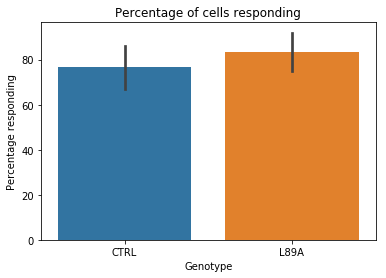

In [6]:
# call the newly created `plot_traces' function (output is suppressed)
plot_traces(df=ca_data, plot=False)

#Plot average number of responding cells per slide for each cell type
filtered_data = percentage_response(ca_data, threshold=1.1, utp_range=(40,480))


In [7]:
#step 1: Make a new empty dataframe outside the for loop
#step 2: To get desired column, [idx] --> type of a panda series
#step 3: 1st reinteration, concatenate new data frame 
#step 4: concatenate with next dataframe



def combined_data(df):
    """
    this function combines data from different 
    coverslips of the same cell type 
    into 1 data frame using regular expression
    
    ------------------------------
    arguments:
    df        - filtered data from `ca_response_rate` function
    """
    column_names = df.columns
    ctrl_data = pd.DataFrame()
    l89a_data = pd.DataFrame()

    #print(column_names)
    pattern = re.compile("CTRL.*")
    for column_name in column_names:
        if pattern.match(column_name):
            temp1 = {column_name: filtered_data[column_name]}
            ctrl_data = pd.concat([ctrl_data, pd.DataFrame(temp1)], axis=1)
        else:
            temp2 = {column_name: filtered_data[column_name]}
            l89a_data = pd.concat([l89a_data, pd.DataFrame(temp2)], axis=1)
        
    return ctrl_data, l89a_data
            

In [8]:
ctrl_data, l89a_data = combined_data(df=filtered_data)

In [21]:
def max_amp_plot(df, utp_range=(40, 480), title='none'):
    """
    document me!
    """
    column_names = df.columns
    d = {}
    for column_name in column_names: 
        df_max = df.iloc[utp_range[0]:utp_range[1], :].max()
        df_max.plot.box(title=title) 
        
    return df_max


<class 'pandas.core.series.Series'>


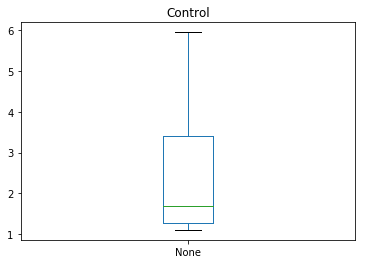

In [22]:
ctrl_max = max_amp_plot(df=ctrl_data, utp_range=(40, 480), title='Control')
print(type(ctrl_max))


#def max_amp_plot(df, col_names, utp_range=(40, 480), title):
#calc_response_rate(df=ca_data, threshold=1.2, utp_range=(40, 480), verbose=True, plot=True)

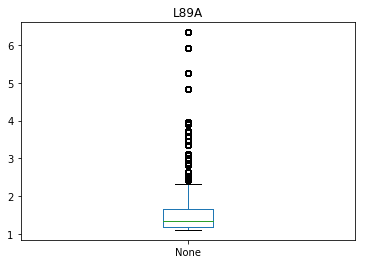

In [23]:
l89a_max = max_amp_plot(df=l89a_data, utp_range=(40, 480), title='L89A')

In [12]:
##scipy.stats.ttest_ind(a, b, axis=0, equal_var=True, nan_policy='propagate')[source]
print(stats.ttest_ind(a=ctrl_max, b=l89a_max))

Ttest_indResult(statistic=6.312261869708858, pvalue=7.503398705037498e-10)


In [13]:
#correct if the population S.D. is expected to be equal for the two groups.
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

In [14]:
effect_size = cohen_d(x=ctrl_max, y=l89a_max)
print(effect_size)

#ctrl_max = max_amp_plot(df=ctrl_data, col_names=column_names, utp_range=(40, 480), title='Control')

0.638702413381654


In [15]:
def make_df(cols, ind):
    """Quickly make a DataFrame"""
    time = (np.linspace(0,299.75,1200))
    data = {c: [str(c) + str(i) for i in time]
            for c in cols}
    return pd.DataFrame(data, ind)

# example DataFrame
time_column = make_df('A', range(1200))
time_column =pd.DataFrame(time_column)
#time_column = time_column.reset_index()
#time_column = time_column.drop(time_column.columns[1], axis=1)
print(time_column)

            A
0        A0.0
1       A0.25
2        A0.5
3       A0.75
4        A1.0
5       A1.25
6        A1.5
7       A1.75
8        A2.0
9       A2.25
10       A2.5
11      A2.75
12       A3.0
13      A3.25
14       A3.5
15      A3.75
16       A4.0
17      A4.25
18       A4.5
19      A4.75
20       A5.0
21      A5.25
22       A5.5
23      A5.75
24       A6.0
25      A6.25
26       A6.5
27      A6.75
28       A7.0
29      A7.25
...       ...
1170   A292.5
1171  A292.75
1172   A293.0
1173  A293.25
1174   A293.5
1175  A293.75
1176   A294.0
1177  A294.25
1178   A294.5
1179  A294.75
1180   A295.0
1181  A295.25
1182   A295.5
1183  A295.75
1184   A296.0
1185  A296.25
1186   A296.5
1187  A296.75
1188   A297.0
1189  A297.25
1190   A297.5
1191  A297.75
1192   A298.0
1193  A298.25
1194   A298.5
1195  A298.75
1196   A299.0
1197  A299.25
1198   A299.5
1199  A299.75

[1200 rows x 1 columns]


In [16]:
# make a list of the header row and strip up to the 4th letter. This is the location and year information
column_name = ctrl_data.columns
genotype = [str(x)[:4] for x in column_name]
coverslip=[str(x)[4:5] for x in column_name]
cell_no=[str(x)[6:] for x in column_name]
time = pd.DataFrame({'Time (s)': np.linspace(0,299.75,1200)})

d = {'Genotype': genotype, 'Coverslip': coverslip, 'Cell number': cell_no}
e = pd.DataFrame(d)
f = time_column.join(ctrl_data)
f = f.set_index('A')
#print(f)
f = f.transpose()
#print(f)
f = f.reset_index()
f = f.drop('index', axis=1)
tidy_ctrl = e.join(f)
print(tidy_ctrl)

    Genotype Coverslip Cell number      A0.0     A0.25      A0.5     A0.75  \
0       CTRL         1          34  1.026559  1.007801  1.027962  0.986153   
1       CTRL         1           2  1.045328  1.026162  1.049161  1.003324   
2       CTRL         1          36  1.012209  0.996418  1.012916  0.988547   
3       CTRL         1          19  1.037352  1.015074  1.043062  0.994477   
4       CTRL         1           1  1.035578  1.015798  1.033718  1.002494   
5       CTRL         1          27  1.005640  0.988017  1.007085  0.981290   
6       CTRL         1           5  1.052427  1.031283  1.048379  1.023790   
7       CTRL         1          20  1.038200  1.019180  1.040489  1.005061   
8       CTRL         1          11  1.059934  1.031377  1.048883  1.018804   
9       CTRL         1          32  1.120071  1.096846  1.117054  1.083871   
10      CTRL         1          24  1.029760  1.008596  1.024478  1.002312   
11      CTRL         1          16  1.051100  1.027636  1.047978

In [17]:
# make a list of the header row and strip up to the 4th letter. This is the location and year information
column_name_l89a = l89a_data.columns
genotype_a = [str(x)[:4] for x in column_name_l89a]
coverslip_a=[str(x)[4:5] for x in column_name_l89a]
cell_no_a=[str(x)[6:] for x in column_name_l89a]

g = {'Genotype': genotype_a, 'Coverslip': coverslip_a, 'Cell number': cell_no_a}
h = pd.DataFrame(g)
i = time_column.join(l89a_data)
i = i.set_index('A')
#print(f)
i = i.transpose()
#print(f)
i = i.reset_index()
i = i.drop('index', axis=1)
tidy_l89a = h.join(i)
print(tidy_l89a)


    Genotype Coverslip Cell number      A0.0     A0.25      A0.5     A0.75  \
0       L89A         1          23  1.028371  1.026377  1.018966  1.015225   
1       L89A         1          22  1.032828  1.027198  1.018640  1.017367   
2       L89A         1           9  1.002090  1.002384  0.999406  0.997997   
3       L89A         1          25  0.992971  0.988455  0.981492  0.979588   
4       L89A         1           7  0.957930  0.952478  0.947580  0.948976   
5       L89A         1          16  1.006539  1.003798  0.998070  0.996956   
6       L89A         1          24  0.996547  0.993885  0.986706  0.990568   
7       L89A         1          10  1.067948  1.063004  1.055342  1.055454   
8       L89A         1          31  1.011672  1.005320  0.999555  1.002856   
9       L89A         1          19  1.033705  1.030523  1.024123  1.022106   
10      L89A         1           6  0.990683  0.987408  0.982672  0.984607   
11      L89A         1          20  1.007404  1.000798  0.997064

In [18]:
total_data = pd.concat([tidy_ctrl, tidy_l89a], axis=0, ignore_index=True)
tidy = pd.DataFrame()
times = pd.DataFrame({'Time (s)': np.linspace(0,299.75,1200)})
for i, row in total_data.iterrows():
    #print('this is a new row')
    temp1 = total_data.iloc[i:i+1, 0:3]
    temp2 = pd.concat([temp1]*1200, ignore_index=True)
    temp3 = time.join(temp2, sort=True)
    
    temp4 = total_data.iloc[i:i+1, 3:1204]
    temp5 = temp4.T
    temp6 = temp5.reset_index()
    temp7 = temp6.rename(columns = {temp6.columns[1]: 'F/Fo'})
    temp8 = temp7.iloc[:,1]
    temp9 = temp3.join(temp8)
    tidy = pd.concat([tidy, temp9], ignore_index=True)
    print(tidy)
print(tidy)
    



      Time (s) Genotype Coverslip Cell number      F/Fo
0         0.00     CTRL         1          34  1.026559
1         0.25     CTRL         1          34  1.007801
2         0.50     CTRL         1          34  1.027962
3         0.75     CTRL         1          34  0.986153
4         1.00     CTRL         1          34  1.008667
5         1.25     CTRL         1          34  0.986112
6         1.50     CTRL         1          34  1.004107
7         1.75     CTRL         1          34  1.007966
8         2.00     CTRL         1          34  0.997874
9         2.25     CTRL         1          34  1.013001
10        2.50     CTRL         1          34  1.003137
11        2.75     CTRL         1          34  1.010112
12        3.00     CTRL         1          34  1.006212
13        3.25     CTRL         1          34  0.998349
14        3.50     CTRL         1          34  0.994758
15        3.75     CTRL         1          34  1.003075
16        4.00     CTRL         1          34  1

      Time (s) Genotype Coverslip Cell number      F/Fo
0         0.00     CTRL         1          34  1.026559
1         0.25     CTRL         1          34  1.007801
2         0.50     CTRL         1          34  1.027962
3         0.75     CTRL         1          34  0.986153
4         1.00     CTRL         1          34  1.008667
5         1.25     CTRL         1          34  0.986112
6         1.50     CTRL         1          34  1.004107
7         1.75     CTRL         1          34  1.007966
8         2.00     CTRL         1          34  0.997874
9         2.25     CTRL         1          34  1.013001
10        2.50     CTRL         1          34  1.003137
11        2.75     CTRL         1          34  1.010112
12        3.00     CTRL         1          34  1.006212
13        3.25     CTRL         1          34  0.998349
14        3.50     CTRL         1          34  0.994758
15        3.75     CTRL         1          34  1.003075
16        4.00     CTRL         1          34  1

       Time (s) Genotype Coverslip Cell number      F/Fo
0          0.00     CTRL         1          34  1.026559
1          0.25     CTRL         1          34  1.007801
2          0.50     CTRL         1          34  1.027962
3          0.75     CTRL         1          34  0.986153
4          1.00     CTRL         1          34  1.008667
5          1.25     CTRL         1          34  0.986112
6          1.50     CTRL         1          34  1.004107
7          1.75     CTRL         1          34  1.007966
8          2.00     CTRL         1          34  0.997874
9          2.25     CTRL         1          34  1.013001
10         2.50     CTRL         1          34  1.003137
11         2.75     CTRL         1          34  1.010112
12         3.00     CTRL         1          34  1.006212
13         3.25     CTRL         1          34  0.998349
14         3.50     CTRL         1          34  0.994758
15         3.75     CTRL         1          34  1.003075
16         4.00     CTRL       

       Time (s) Genotype Coverslip Cell number      F/Fo
0          0.00     CTRL         1          34  1.026559
1          0.25     CTRL         1          34  1.007801
2          0.50     CTRL         1          34  1.027962
3          0.75     CTRL         1          34  0.986153
4          1.00     CTRL         1          34  1.008667
5          1.25     CTRL         1          34  0.986112
6          1.50     CTRL         1          34  1.004107
7          1.75     CTRL         1          34  1.007966
8          2.00     CTRL         1          34  0.997874
9          2.25     CTRL         1          34  1.013001
10         2.50     CTRL         1          34  1.003137
11         2.75     CTRL         1          34  1.010112
12         3.00     CTRL         1          34  1.006212
13         3.25     CTRL         1          34  0.998349
14         3.50     CTRL         1          34  0.994758
15         3.75     CTRL         1          34  1.003075
16         4.00     CTRL       

       Time (s) Genotype Coverslip Cell number      F/Fo
0          0.00     CTRL         1          34  1.026559
1          0.25     CTRL         1          34  1.007801
2          0.50     CTRL         1          34  1.027962
3          0.75     CTRL         1          34  0.986153
4          1.00     CTRL         1          34  1.008667
5          1.25     CTRL         1          34  0.986112
6          1.50     CTRL         1          34  1.004107
7          1.75     CTRL         1          34  1.007966
8          2.00     CTRL         1          34  0.997874
9          2.25     CTRL         1          34  1.013001
10         2.50     CTRL         1          34  1.003137
11         2.75     CTRL         1          34  1.010112
12         3.00     CTRL         1          34  1.006212
13         3.25     CTRL         1          34  0.998349
14         3.50     CTRL         1          34  0.994758
15         3.75     CTRL         1          34  1.003075
16         4.00     CTRL       

       Time (s) Genotype Coverslip Cell number      F/Fo
0          0.00     CTRL         1          34  1.026559
1          0.25     CTRL         1          34  1.007801
2          0.50     CTRL         1          34  1.027962
3          0.75     CTRL         1          34  0.986153
4          1.00     CTRL         1          34  1.008667
5          1.25     CTRL         1          34  0.986112
6          1.50     CTRL         1          34  1.004107
7          1.75     CTRL         1          34  1.007966
8          2.00     CTRL         1          34  0.997874
9          2.25     CTRL         1          34  1.013001
10         2.50     CTRL         1          34  1.003137
11         2.75     CTRL         1          34  1.010112
12         3.00     CTRL         1          34  1.006212
13         3.25     CTRL         1          34  0.998349
14         3.50     CTRL         1          34  0.994758
15         3.75     CTRL         1          34  1.003075
16         4.00     CTRL       

       Time (s) Genotype Coverslip Cell number      F/Fo
0          0.00     CTRL         1          34  1.026559
1          0.25     CTRL         1          34  1.007801
2          0.50     CTRL         1          34  1.027962
3          0.75     CTRL         1          34  0.986153
4          1.00     CTRL         1          34  1.008667
5          1.25     CTRL         1          34  0.986112
6          1.50     CTRL         1          34  1.004107
7          1.75     CTRL         1          34  1.007966
8          2.00     CTRL         1          34  0.997874
9          2.25     CTRL         1          34  1.013001
10         2.50     CTRL         1          34  1.003137
11         2.75     CTRL         1          34  1.010112
12         3.00     CTRL         1          34  1.006212
13         3.25     CTRL         1          34  0.998349
14         3.50     CTRL         1          34  0.994758
15         3.75     CTRL         1          34  1.003075
16         4.00     CTRL       

       Time (s) Genotype Coverslip Cell number      F/Fo
0          0.00     CTRL         1          34  1.026559
1          0.25     CTRL         1          34  1.007801
2          0.50     CTRL         1          34  1.027962
3          0.75     CTRL         1          34  0.986153
4          1.00     CTRL         1          34  1.008667
5          1.25     CTRL         1          34  0.986112
6          1.50     CTRL         1          34  1.004107
7          1.75     CTRL         1          34  1.007966
8          2.00     CTRL         1          34  0.997874
9          2.25     CTRL         1          34  1.013001
10         2.50     CTRL         1          34  1.003137
11         2.75     CTRL         1          34  1.010112
12         3.00     CTRL         1          34  1.006212
13         3.25     CTRL         1          34  0.998349
14         3.50     CTRL         1          34  0.994758
15         3.75     CTRL         1          34  1.003075
16         4.00     CTRL       

       Time (s) Genotype Coverslip Cell number      F/Fo
0          0.00     CTRL         1          34  1.026559
1          0.25     CTRL         1          34  1.007801
2          0.50     CTRL         1          34  1.027962
3          0.75     CTRL         1          34  0.986153
4          1.00     CTRL         1          34  1.008667
5          1.25     CTRL         1          34  0.986112
6          1.50     CTRL         1          34  1.004107
7          1.75     CTRL         1          34  1.007966
8          2.00     CTRL         1          34  0.997874
9          2.25     CTRL         1          34  1.013001
10         2.50     CTRL         1          34  1.003137
11         2.75     CTRL         1          34  1.010112
12         3.00     CTRL         1          34  1.006212
13         3.25     CTRL         1          34  0.998349
14         3.50     CTRL         1          34  0.994758
15         3.75     CTRL         1          34  1.003075
16         4.00     CTRL       

       Time (s) Genotype Coverslip Cell number      F/Fo
0          0.00     CTRL         1          34  1.026559
1          0.25     CTRL         1          34  1.007801
2          0.50     CTRL         1          34  1.027962
3          0.75     CTRL         1          34  0.986153
4          1.00     CTRL         1          34  1.008667
5          1.25     CTRL         1          34  0.986112
6          1.50     CTRL         1          34  1.004107
7          1.75     CTRL         1          34  1.007966
8          2.00     CTRL         1          34  0.997874
9          2.25     CTRL         1          34  1.013001
10         2.50     CTRL         1          34  1.003137
11         2.75     CTRL         1          34  1.010112
12         3.00     CTRL         1          34  1.006212
13         3.25     CTRL         1          34  0.998349
14         3.50     CTRL         1          34  0.994758
15         3.75     CTRL         1          34  1.003075
16         4.00     CTRL       

       Time (s) Genotype Coverslip Cell number      F/Fo
0          0.00     CTRL         1          34  1.026559
1          0.25     CTRL         1          34  1.007801
2          0.50     CTRL         1          34  1.027962
3          0.75     CTRL         1          34  0.986153
4          1.00     CTRL         1          34  1.008667
5          1.25     CTRL         1          34  0.986112
6          1.50     CTRL         1          34  1.004107
7          1.75     CTRL         1          34  1.007966
8          2.00     CTRL         1          34  0.997874
9          2.25     CTRL         1          34  1.013001
10         2.50     CTRL         1          34  1.003137
11         2.75     CTRL         1          34  1.010112
12         3.00     CTRL         1          34  1.006212
13         3.25     CTRL         1          34  0.998349
14         3.50     CTRL         1          34  0.994758
15         3.75     CTRL         1          34  1.003075
16         4.00     CTRL       

       Time (s) Genotype Coverslip Cell number      F/Fo
0          0.00     CTRL         1          34  1.026559
1          0.25     CTRL         1          34  1.007801
2          0.50     CTRL         1          34  1.027962
3          0.75     CTRL         1          34  0.986153
4          1.00     CTRL         1          34  1.008667
5          1.25     CTRL         1          34  0.986112
6          1.50     CTRL         1          34  1.004107
7          1.75     CTRL         1          34  1.007966
8          2.00     CTRL         1          34  0.997874
9          2.25     CTRL         1          34  1.013001
10         2.50     CTRL         1          34  1.003137
11         2.75     CTRL         1          34  1.010112
12         3.00     CTRL         1          34  1.006212
13         3.25     CTRL         1          34  0.998349
14         3.50     CTRL         1          34  0.994758
15         3.75     CTRL         1          34  1.003075
16         4.00     CTRL       

       Time (s) Genotype Coverslip Cell number      F/Fo
0          0.00     CTRL         1          34  1.026559
1          0.25     CTRL         1          34  1.007801
2          0.50     CTRL         1          34  1.027962
3          0.75     CTRL         1          34  0.986153
4          1.00     CTRL         1          34  1.008667
5          1.25     CTRL         1          34  0.986112
6          1.50     CTRL         1          34  1.004107
7          1.75     CTRL         1          34  1.007966
8          2.00     CTRL         1          34  0.997874
9          2.25     CTRL         1          34  1.013001
10         2.50     CTRL         1          34  1.003137
11         2.75     CTRL         1          34  1.010112
12         3.00     CTRL         1          34  1.006212
13         3.25     CTRL         1          34  0.998349
14         3.50     CTRL         1          34  0.994758
15         3.75     CTRL         1          34  1.003075
16         4.00     CTRL       

       Time (s) Genotype Coverslip Cell number      F/Fo
0          0.00     CTRL         1          34  1.026559
1          0.25     CTRL         1          34  1.007801
2          0.50     CTRL         1          34  1.027962
3          0.75     CTRL         1          34  0.986153
4          1.00     CTRL         1          34  1.008667
5          1.25     CTRL         1          34  0.986112
6          1.50     CTRL         1          34  1.004107
7          1.75     CTRL         1          34  1.007966
8          2.00     CTRL         1          34  0.997874
9          2.25     CTRL         1          34  1.013001
10         2.50     CTRL         1          34  1.003137
11         2.75     CTRL         1          34  1.010112
12         3.00     CTRL         1          34  1.006212
13         3.25     CTRL         1          34  0.998349
14         3.50     CTRL         1          34  0.994758
15         3.75     CTRL         1          34  1.003075
16         4.00     CTRL       

       Time (s) Genotype Coverslip Cell number      F/Fo
0          0.00     CTRL         1          34  1.026559
1          0.25     CTRL         1          34  1.007801
2          0.50     CTRL         1          34  1.027962
3          0.75     CTRL         1          34  0.986153
4          1.00     CTRL         1          34  1.008667
5          1.25     CTRL         1          34  0.986112
6          1.50     CTRL         1          34  1.004107
7          1.75     CTRL         1          34  1.007966
8          2.00     CTRL         1          34  0.997874
9          2.25     CTRL         1          34  1.013001
10         2.50     CTRL         1          34  1.003137
11         2.75     CTRL         1          34  1.010112
12         3.00     CTRL         1          34  1.006212
13         3.25     CTRL         1          34  0.998349
14         3.50     CTRL         1          34  0.994758
15         3.75     CTRL         1          34  1.003075
16         4.00     CTRL       

       Time (s) Genotype Coverslip Cell number      F/Fo
0          0.00     CTRL         1          34  1.026559
1          0.25     CTRL         1          34  1.007801
2          0.50     CTRL         1          34  1.027962
3          0.75     CTRL         1          34  0.986153
4          1.00     CTRL         1          34  1.008667
5          1.25     CTRL         1          34  0.986112
6          1.50     CTRL         1          34  1.004107
7          1.75     CTRL         1          34  1.007966
8          2.00     CTRL         1          34  0.997874
9          2.25     CTRL         1          34  1.013001
10         2.50     CTRL         1          34  1.003137
11         2.75     CTRL         1          34  1.010112
12         3.00     CTRL         1          34  1.006212
13         3.25     CTRL         1          34  0.998349
14         3.50     CTRL         1          34  0.994758
15         3.75     CTRL         1          34  1.003075
16         4.00     CTRL       

       Time (s) Genotype Coverslip Cell number      F/Fo
0          0.00     CTRL         1          34  1.026559
1          0.25     CTRL         1          34  1.007801
2          0.50     CTRL         1          34  1.027962
3          0.75     CTRL         1          34  0.986153
4          1.00     CTRL         1          34  1.008667
5          1.25     CTRL         1          34  0.986112
6          1.50     CTRL         1          34  1.004107
7          1.75     CTRL         1          34  1.007966
8          2.00     CTRL         1          34  0.997874
9          2.25     CTRL         1          34  1.013001
10         2.50     CTRL         1          34  1.003137
11         2.75     CTRL         1          34  1.010112
12         3.00     CTRL         1          34  1.006212
13         3.25     CTRL         1          34  0.998349
14         3.50     CTRL         1          34  0.994758
15         3.75     CTRL         1          34  1.003075
16         4.00     CTRL       

       Time (s) Genotype Coverslip Cell number      F/Fo
0          0.00     CTRL         1          34  1.026559
1          0.25     CTRL         1          34  1.007801
2          0.50     CTRL         1          34  1.027962
3          0.75     CTRL         1          34  0.986153
4          1.00     CTRL         1          34  1.008667
5          1.25     CTRL         1          34  0.986112
6          1.50     CTRL         1          34  1.004107
7          1.75     CTRL         1          34  1.007966
8          2.00     CTRL         1          34  0.997874
9          2.25     CTRL         1          34  1.013001
10         2.50     CTRL         1          34  1.003137
11         2.75     CTRL         1          34  1.010112
12         3.00     CTRL         1          34  1.006212
13         3.25     CTRL         1          34  0.998349
14         3.50     CTRL         1          34  0.994758
15         3.75     CTRL         1          34  1.003075
16         4.00     CTRL       

       Time (s) Genotype Coverslip Cell number      F/Fo
0          0.00     CTRL         1          34  1.026559
1          0.25     CTRL         1          34  1.007801
2          0.50     CTRL         1          34  1.027962
3          0.75     CTRL         1          34  0.986153
4          1.00     CTRL         1          34  1.008667
5          1.25     CTRL         1          34  0.986112
6          1.50     CTRL         1          34  1.004107
7          1.75     CTRL         1          34  1.007966
8          2.00     CTRL         1          34  0.997874
9          2.25     CTRL         1          34  1.013001
10         2.50     CTRL         1          34  1.003137
11         2.75     CTRL         1          34  1.010112
12         3.00     CTRL         1          34  1.006212
13         3.25     CTRL         1          34  0.998349
14         3.50     CTRL         1          34  0.994758
15         3.75     CTRL         1          34  1.003075
16         4.00     CTRL       

       Time (s) Genotype Coverslip Cell number      F/Fo
0          0.00     CTRL         1          34  1.026559
1          0.25     CTRL         1          34  1.007801
2          0.50     CTRL         1          34  1.027962
3          0.75     CTRL         1          34  0.986153
4          1.00     CTRL         1          34  1.008667
5          1.25     CTRL         1          34  0.986112
6          1.50     CTRL         1          34  1.004107
7          1.75     CTRL         1          34  1.007966
8          2.00     CTRL         1          34  0.997874
9          2.25     CTRL         1          34  1.013001
10         2.50     CTRL         1          34  1.003137
11         2.75     CTRL         1          34  1.010112
12         3.00     CTRL         1          34  1.006212
13         3.25     CTRL         1          34  0.998349
14         3.50     CTRL         1          34  0.994758
15         3.75     CTRL         1          34  1.003075
16         4.00     CTRL       

       Time (s) Genotype Coverslip Cell number      F/Fo
0          0.00     CTRL         1          34  1.026559
1          0.25     CTRL         1          34  1.007801
2          0.50     CTRL         1          34  1.027962
3          0.75     CTRL         1          34  0.986153
4          1.00     CTRL         1          34  1.008667
5          1.25     CTRL         1          34  0.986112
6          1.50     CTRL         1          34  1.004107
7          1.75     CTRL         1          34  1.007966
8          2.00     CTRL         1          34  0.997874
9          2.25     CTRL         1          34  1.013001
10         2.50     CTRL         1          34  1.003137
11         2.75     CTRL         1          34  1.010112
12         3.00     CTRL         1          34  1.006212
13         3.25     CTRL         1          34  0.998349
14         3.50     CTRL         1          34  0.994758
15         3.75     CTRL         1          34  1.003075
16         4.00     CTRL       

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

        Time (s) Genotype Coverslip Cell number      F/Fo
0           0.00     CTRL         1          34  1.026559
1           0.25     CTRL         1          34  1.007801
2           0.50     CTRL         1          34  1.027962
3           0.75     CTRL         1          34  0.986153
4           1.00     CTRL         1          34  1.008667
5           1.25     CTRL         1          34  0.986112
6           1.50     CTRL         1          34  1.004107
7           1.75     CTRL         1          34  1.007966
8           2.00     CTRL         1          34  0.997874
9           2.25     CTRL         1          34  1.013001
10          2.50     CTRL         1          34  1.003137
11          2.75     CTRL         1          34  1.010112
12          3.00     CTRL         1          34  1.006212
13          3.25     CTRL         1          34  0.998349
14          3.50     CTRL         1          34  0.994758
15          3.75     CTRL         1          34  1.003075
16          4.

In [19]:
tidy.head()

,Time (s),Genotype,Coverslip,Cell number,F/Fo
0,0.00,CTRL,1,34,1.026559
1,0.25,CTRL,1,34,1.007801
2,0.50,CTRL,1,34,1.027962
3,0.75,CTRL,1,34,0.986153
4,1.00,CTRL,1,34,1.008667


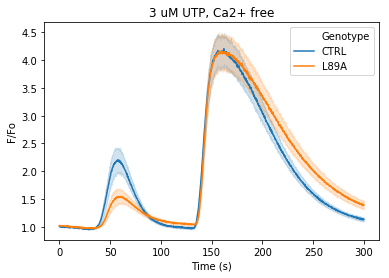

In [20]:
ax = sns.lineplot(x="Time (s)", y="F/Fo", hue="Genotype", ci=99, data=tidy).set_title('3 uM UTP, Ca2+ free')


In [25]:
writer = pd.ExcelWriter('CTRL_L89A.xlsx', engine='xlsxwriter')
tidy.to_excel(writer, sheet_name='Sheet1')

In [26]:
writer.save()